## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Paths
BASE_PATH = Path('.')
UNLABELED_PATH = BASE_PATH / 'unlabeled'

print("Setup complete!")

Setup complete!


## 2. Load Main DataFrames

In [2]:
# Load training labels
train_df = pd.read_csv(BASE_PATH / 'train.csv', index_col=0)
print(f"Training set shape: {train_df.shape}")
display(train_df.head(10))
print(f"\nColumns: {train_df.columns.tolist()}")

Training set shape: (50248, 7)


,userid,activity,sensor,body_part,side,id,sequence_length
0,user01,stairs_up,smartwatch,hand,right,3387,3000
1,user01,walking_with_hands_in_pockets,smartwatch,hand,left,8473,4000
2,user08,walking_with_hands_in_pockets,smartwatch,hand,right,74365,3000
3,user01,walking_freely,smartwatch,hand,right,6223,3000
4,user07,using_phone,vicon,hand,left,61641,4000
5,user08,reading_book,smartwatch,hand,right,69741,3500
6,user02,idle,smartwatch,hand,right,11828,3500
7,user01,reading_book,smartwatch,hand,left,1063,3000
8,user05,using_phone,smartwatch,hand,left,42985,3500
9,user01,stairs_up,smartwatch,hand,right,3884,4000



Columns: ['userid', 'activity', 'sensor', 'body_part', 'side', 'id', 'sequence_length']


In [3]:
# Load metadata (unlabeled samples info)
metadata_df = pd.read_csv(BASE_PATH / 'metadata.csv')
print(f"Metadata shape: {metadata_df.shape}")
display(metadata_df.head(10))
print(f"\nColumns: {metadata_df.columns.tolist()}")

Metadata shape: (74744, 6)


,sample_id,userid,sensor,body_part,side,sequence_length
0,1,user01,smartwatch,hand,left,3000
1,9,user01,smartwatch,hand,left,3000
2,12,user01,smartwatch,hand,left,3000
3,16,user01,smartwatch,hand,left,3000
4,17,user01,smartwatch,hand,left,3000
5,25,user01,smartwatch,hand,left,3000
6,27,user01,smartwatch,hand,left,3000
7,28,user01,smartwatch,hand,left,3000
8,30,user01,smartwatch,hand,left,3000
9,31,user01,smartwatch,hand,left,3000



Columns: ['sample_id', 'userid', 'sensor', 'body_part', 'side', 'sequence_length']


In [4]:
# Load sample submission to see target format
sample_sub = pd.read_csv(BASE_PATH / 'sample_submission.csv')
print(f"Sample submission shape: {sample_sub.shape}")
display(sample_sub.head())

# Extract activity classes from submission columns
activity_classes = sample_sub.columns[1:].tolist()
print(f"\n{len(activity_classes)} Activity Classes:")
for i, act in enumerate(activity_classes, 1):
    print(f"  {i}. {act}")

Sample submission shape: (74744, 19)


,sample_id,brushing_teeth,idle,preparing_sandwich,reading_book,stairs_down,stairs_up,typing,using_phone,using_remote_control,walking_freely,walking_holding_a_tray,walking_with_handbag,walking_with_hands_in_pockets,walking_with_object_underarm,washing_face_and_hands,washing_mug,washing_plate,writing
0,1,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556
1,9,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556
2,12,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556
3,16,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556
4,17,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556



18 Activity Classes:
  1. brushing_teeth
  2. idle
  3. preparing_sandwich
  4. reading_book
  5. stairs_down
  6. stairs_up
  7. typing
  8. using_phone
  9. using_remote_control
  10. walking_freely
  11. walking_holding_a_tray
  12. walking_with_handbag
  13. walking_with_hands_in_pockets
  14. walking_with_object_underarm
  15. washing_face_and_hands
  16. washing_mug
  17. washing_plate
  18. writing


## 3. Training Data Analysis

In [5]:
# Basic statistics
print("=" * 60)
print("TRAINING DATA SUMMARY")
print("=" * 60)
print(f"\nTotal samples: {len(train_df):,}")
print(f"Unique users: {train_df['userid'].nunique()}")
print(f"Unique activities: {train_df['activity'].nunique()}")
print(f"Unique sensors: {train_df['sensor'].nunique()}")
print(f"\nData types:")
print(train_df.dtypes)
print(f"\nMissing values:")
print(train_df.isnull().sum())

TRAINING DATA SUMMARY

Total samples: 50,248
Unique users: 8
Unique activities: 18
Unique sensors: 2

Data types:
userid             object
activity           object
sensor             object
body_part          object
side               object
id                  int64
sequence_length     int64
dtype: object

Missing values:
userid             0
activity           0
sensor             0
body_part          0
side               0
id                 0
sequence_length    0
dtype: int64


### 3.1 Activity Distribution (Target Variable)

Activity Distribution:
activity
walking_freely                   4578
walking_with_handbag             4510
walking_holding_a_tray           4441
walking_with_object_underarm     4412
using_phone                      4313
walking_with_hands_in_pockets    4243
idle                             2675
using_remote_control             2552
reading_book                     2508
washing_mug                      2504
washing_plate                    2502
washing_face_and_hands           2490
preparing_sandwich               2242
brushing_teeth                   1435
stairs_up                        1256
writing                          1233
typing                           1199
stairs_down                      1155
Name: count, dtype: int64

Class balance ratio (max/min): 3.96


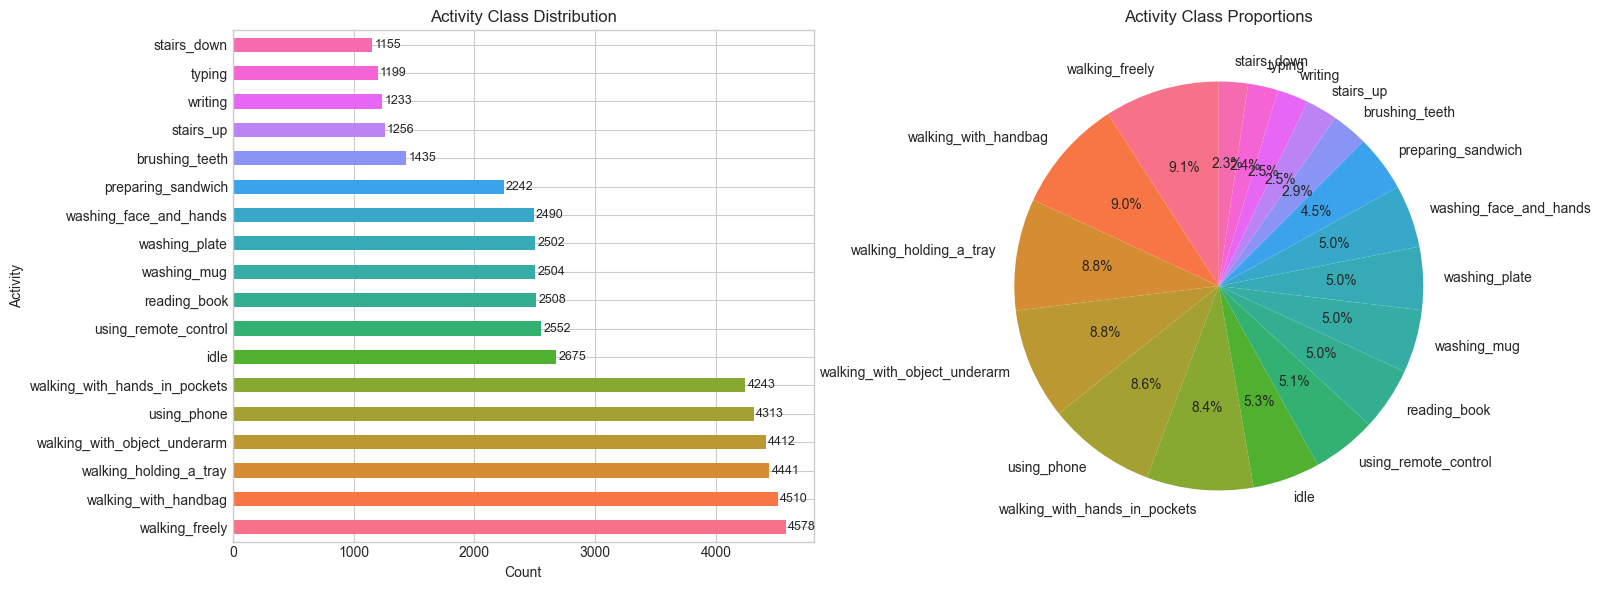

In [6]:
# Activity distribution
activity_counts = train_df['activity'].value_counts()
print("Activity Distribution:")
print(activity_counts)
print(f"\nClass balance ratio (max/min): {activity_counts.max() / activity_counts.min():.2f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
ax1 = axes[0]
colors = sns.color_palette('husl', len(activity_counts))
activity_counts.plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Count')
ax1.set_ylabel('Activity')
ax1.set_title('Activity Class Distribution')
for i, v in enumerate(activity_counts.values):
    ax1.text(v + 20, i, str(v), va='center', fontsize=9)

# Pie chart
ax2 = axes[1]
ax2.pie(activity_counts.values, labels=activity_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('Activity Class Proportions')

plt.tight_layout()
plt.show()

### 3.2 User Distribution

Samples per User:
userid
user01    7387
user02    6102
user03    6492
user04    6348
user05    6262
user06    5571
user07    6331
user08    5755
Name: count, dtype: int64


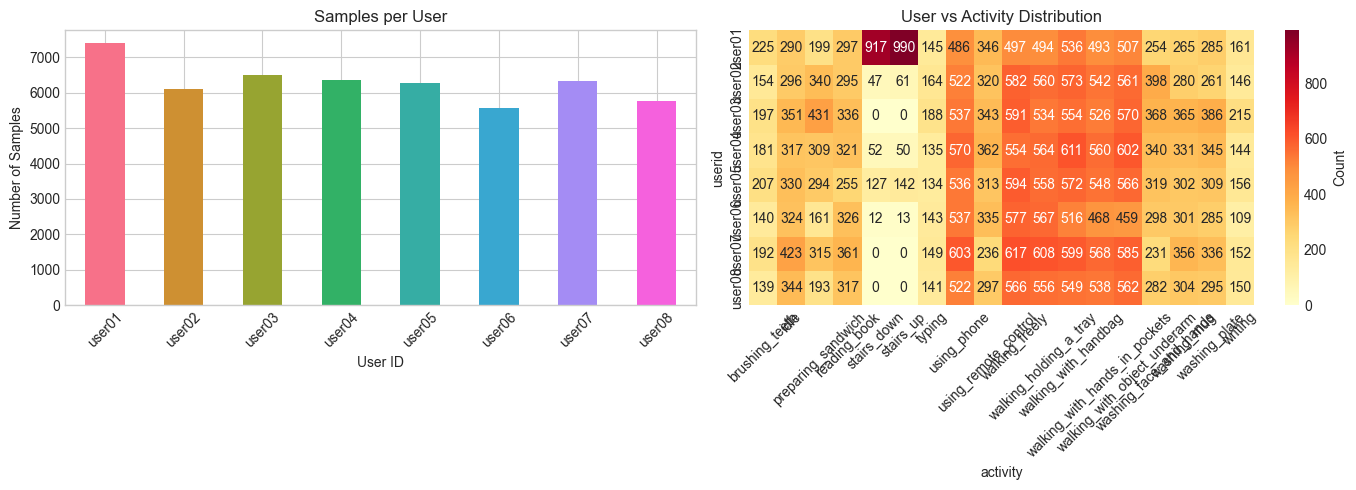

In [7]:
# User distribution
user_counts = train_df['userid'].value_counts().sort_index()
print("Samples per User:")
print(user_counts)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
user_counts.plot(kind='bar', ax=axes[0], color=sns.color_palette('husl', len(user_counts)))
axes[0].set_xlabel('User ID')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Samples per User')
axes[0].tick_params(axis='x', rotation=45)

# User vs Activity heatmap
user_activity = pd.crosstab(train_df['userid'], train_df['activity'])
sns.heatmap(user_activity, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('User vs Activity Distribution')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 3.3 Sensor and Body Part Distribution

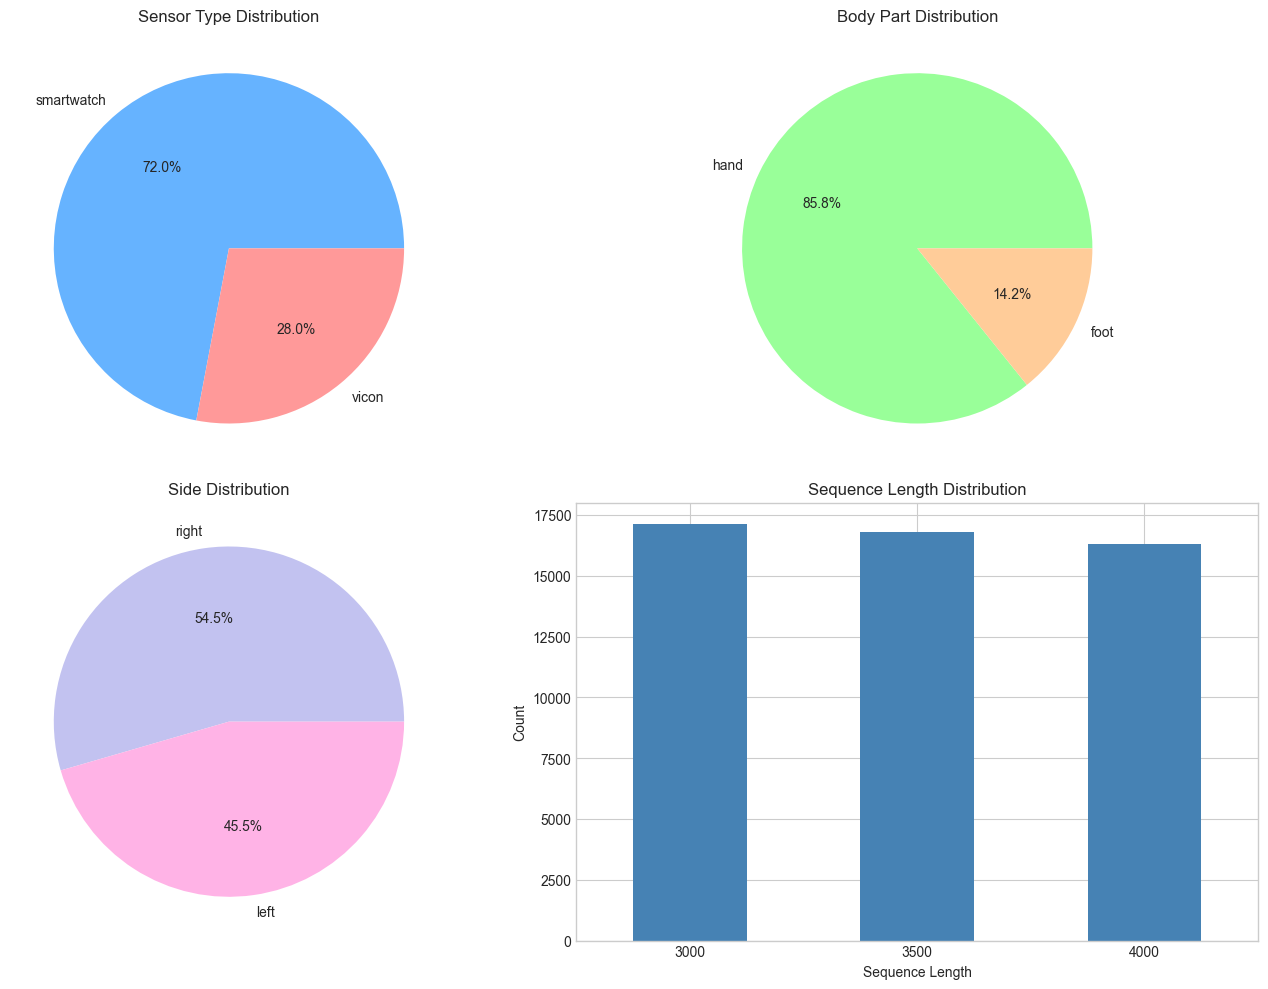


Sequence Length Statistics:
count    50248.000000
mean      3491.760866
std        407.933470
min       3000.000000
25%       3000.000000
50%       3500.000000
75%       4000.000000
max       4000.000000
Name: sequence_length, dtype: float64


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sensor type
sensor_counts = train_df['sensor'].value_counts()
sensor_counts.plot(kind='pie', ax=axes[0, 0], autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
axes[0, 0].set_title('Sensor Type Distribution')
axes[0, 0].set_ylabel('')

# Body part
body_part_counts = train_df['body_part'].value_counts()
body_part_counts.plot(kind='pie', ax=axes[0, 1], autopct='%1.1f%%', colors=['#99ff99', '#ffcc99'])
axes[0, 1].set_title('Body Part Distribution')
axes[0, 1].set_ylabel('')

# Side
side_counts = train_df['side'].value_counts()
side_counts.plot(kind='pie', ax=axes[1, 0], autopct='%1.1f%%', colors=['#c2c2f0', '#ffb3e6'])
axes[1, 0].set_title('Side Distribution')
axes[1, 0].set_ylabel('')

# Sequence length
seq_len_counts = train_df['sequence_length'].value_counts().sort_index()
seq_len_counts.plot(kind='bar', ax=axes[1, 1], color='steelblue')
axes[1, 1].set_xlabel('Sequence Length')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Sequence Length Distribution')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\nSequence Length Statistics:")
print(train_df['sequence_length'].describe())

### 3.4 Cross-tabulations

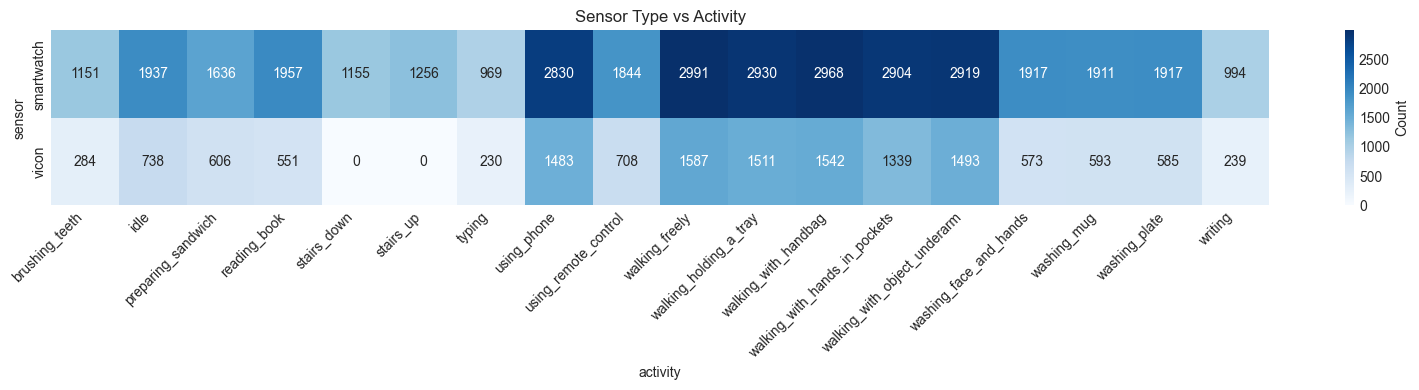

In [9]:
# Sensor vs Activity
sensor_activity = pd.crosstab(train_df['sensor'], train_df['activity'])
plt.figure(figsize=(16, 4))
sns.heatmap(sensor_activity, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Sensor Type vs Activity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

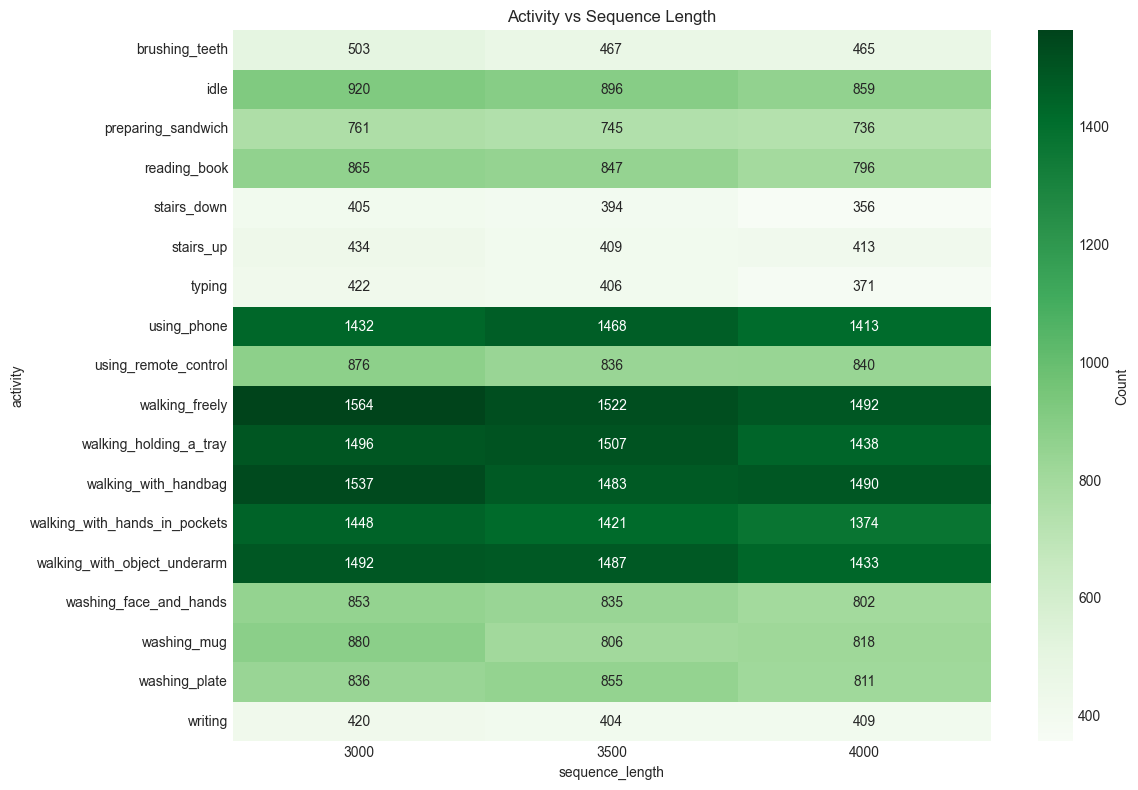

In [10]:
# Activity vs Sequence Length
activity_seq = pd.crosstab(train_df['activity'], train_df['sequence_length'])
plt.figure(figsize=(12, 8))
sns.heatmap(activity_seq, annot=True, fmt='d', cmap='Greens', cbar_kws={'label': 'Count'})
plt.title('Activity vs Sequence Length')
plt.tight_layout()
plt.show()

## 4. Raw Sensor Data Analysis

Let's analyze the two types of raw sensor files:
- **Type #1**: Contains `measurement type, x, y, z` (filter for acceleration rows)
- **Type #2**: Contains `x [m], y [m], z [m]` (position data - use all rows)

In [11]:
def detect_file_type(filepath):
    """Detect if file is Type #1 (sensor) or Type #2 (position)"""
    df = pd.read_csv(filepath, nrows=1)
    if 'measurement type' in df.columns:
        return 'type1'
    elif 'x [m]' in df.columns:
        return 'type2'
    else:
        return 'unknown'

def load_sensor_data(filepath, file_type=None):
    """Load and process sensor data based on file type"""
    if file_type is None:
        file_type = detect_file_type(filepath)
    
    df = pd.read_csv(filepath)
    
    if file_type == 'type1':
        # Filter for acceleration data only
        acc_df = df[df['measurement type'] == 'acceleration [m/s/s]'].copy()
        acc_df = acc_df[['x', 'y', 'z']].reset_index(drop=True)
        acc_df.columns = ['x', 'y', 'z']
        return acc_df, 'acceleration'
    else:
        # Type 2 - position data
        df.columns = ['x', 'y', 'z']
        return df, 'position'

# Test on sample files
print("Testing file type detection...")
for sample_id in [0, 100000]:
    filepath = UNLABELED_PATH / f"{sample_id}.csv"
    if filepath.exists():
        ftype = detect_file_type(filepath)
        print(f"  File {sample_id}.csv: {ftype}")

Testing file type detection...
  File 0.csv: type1
  File 100000.csv: type2


In [12]:
# Analyze file type distribution in training set
print("Analyzing file types in training set (sampling first 500)...")

file_types = {'type1': 0, 'type2': 0, 'unknown': 0, 'missing': 0}
sample_ids = train_df['id'].head(500).tolist()

for sample_id in sample_ids:
    filepath = UNLABELED_PATH / f"{sample_id}.csv"
    if filepath.exists():
        ftype = detect_file_type(filepath)
        file_types[ftype] += 1
    else:
        file_types['missing'] += 1

print(f"\nFile Type Distribution (from 500 samples):")
for k, v in file_types.items():
    print(f"  {k}: {v} ({v/500*100:.1f}%)")

Analyzing file types in training set (sampling first 500)...

File Type Distribution (from 500 samples):
  type1: 351 (70.2%)
  type2: 149 (29.8%)
  unknown: 0 (0.0%)
  missing: 0 (0.0%)


### 4.1 Sample Signal Visualization

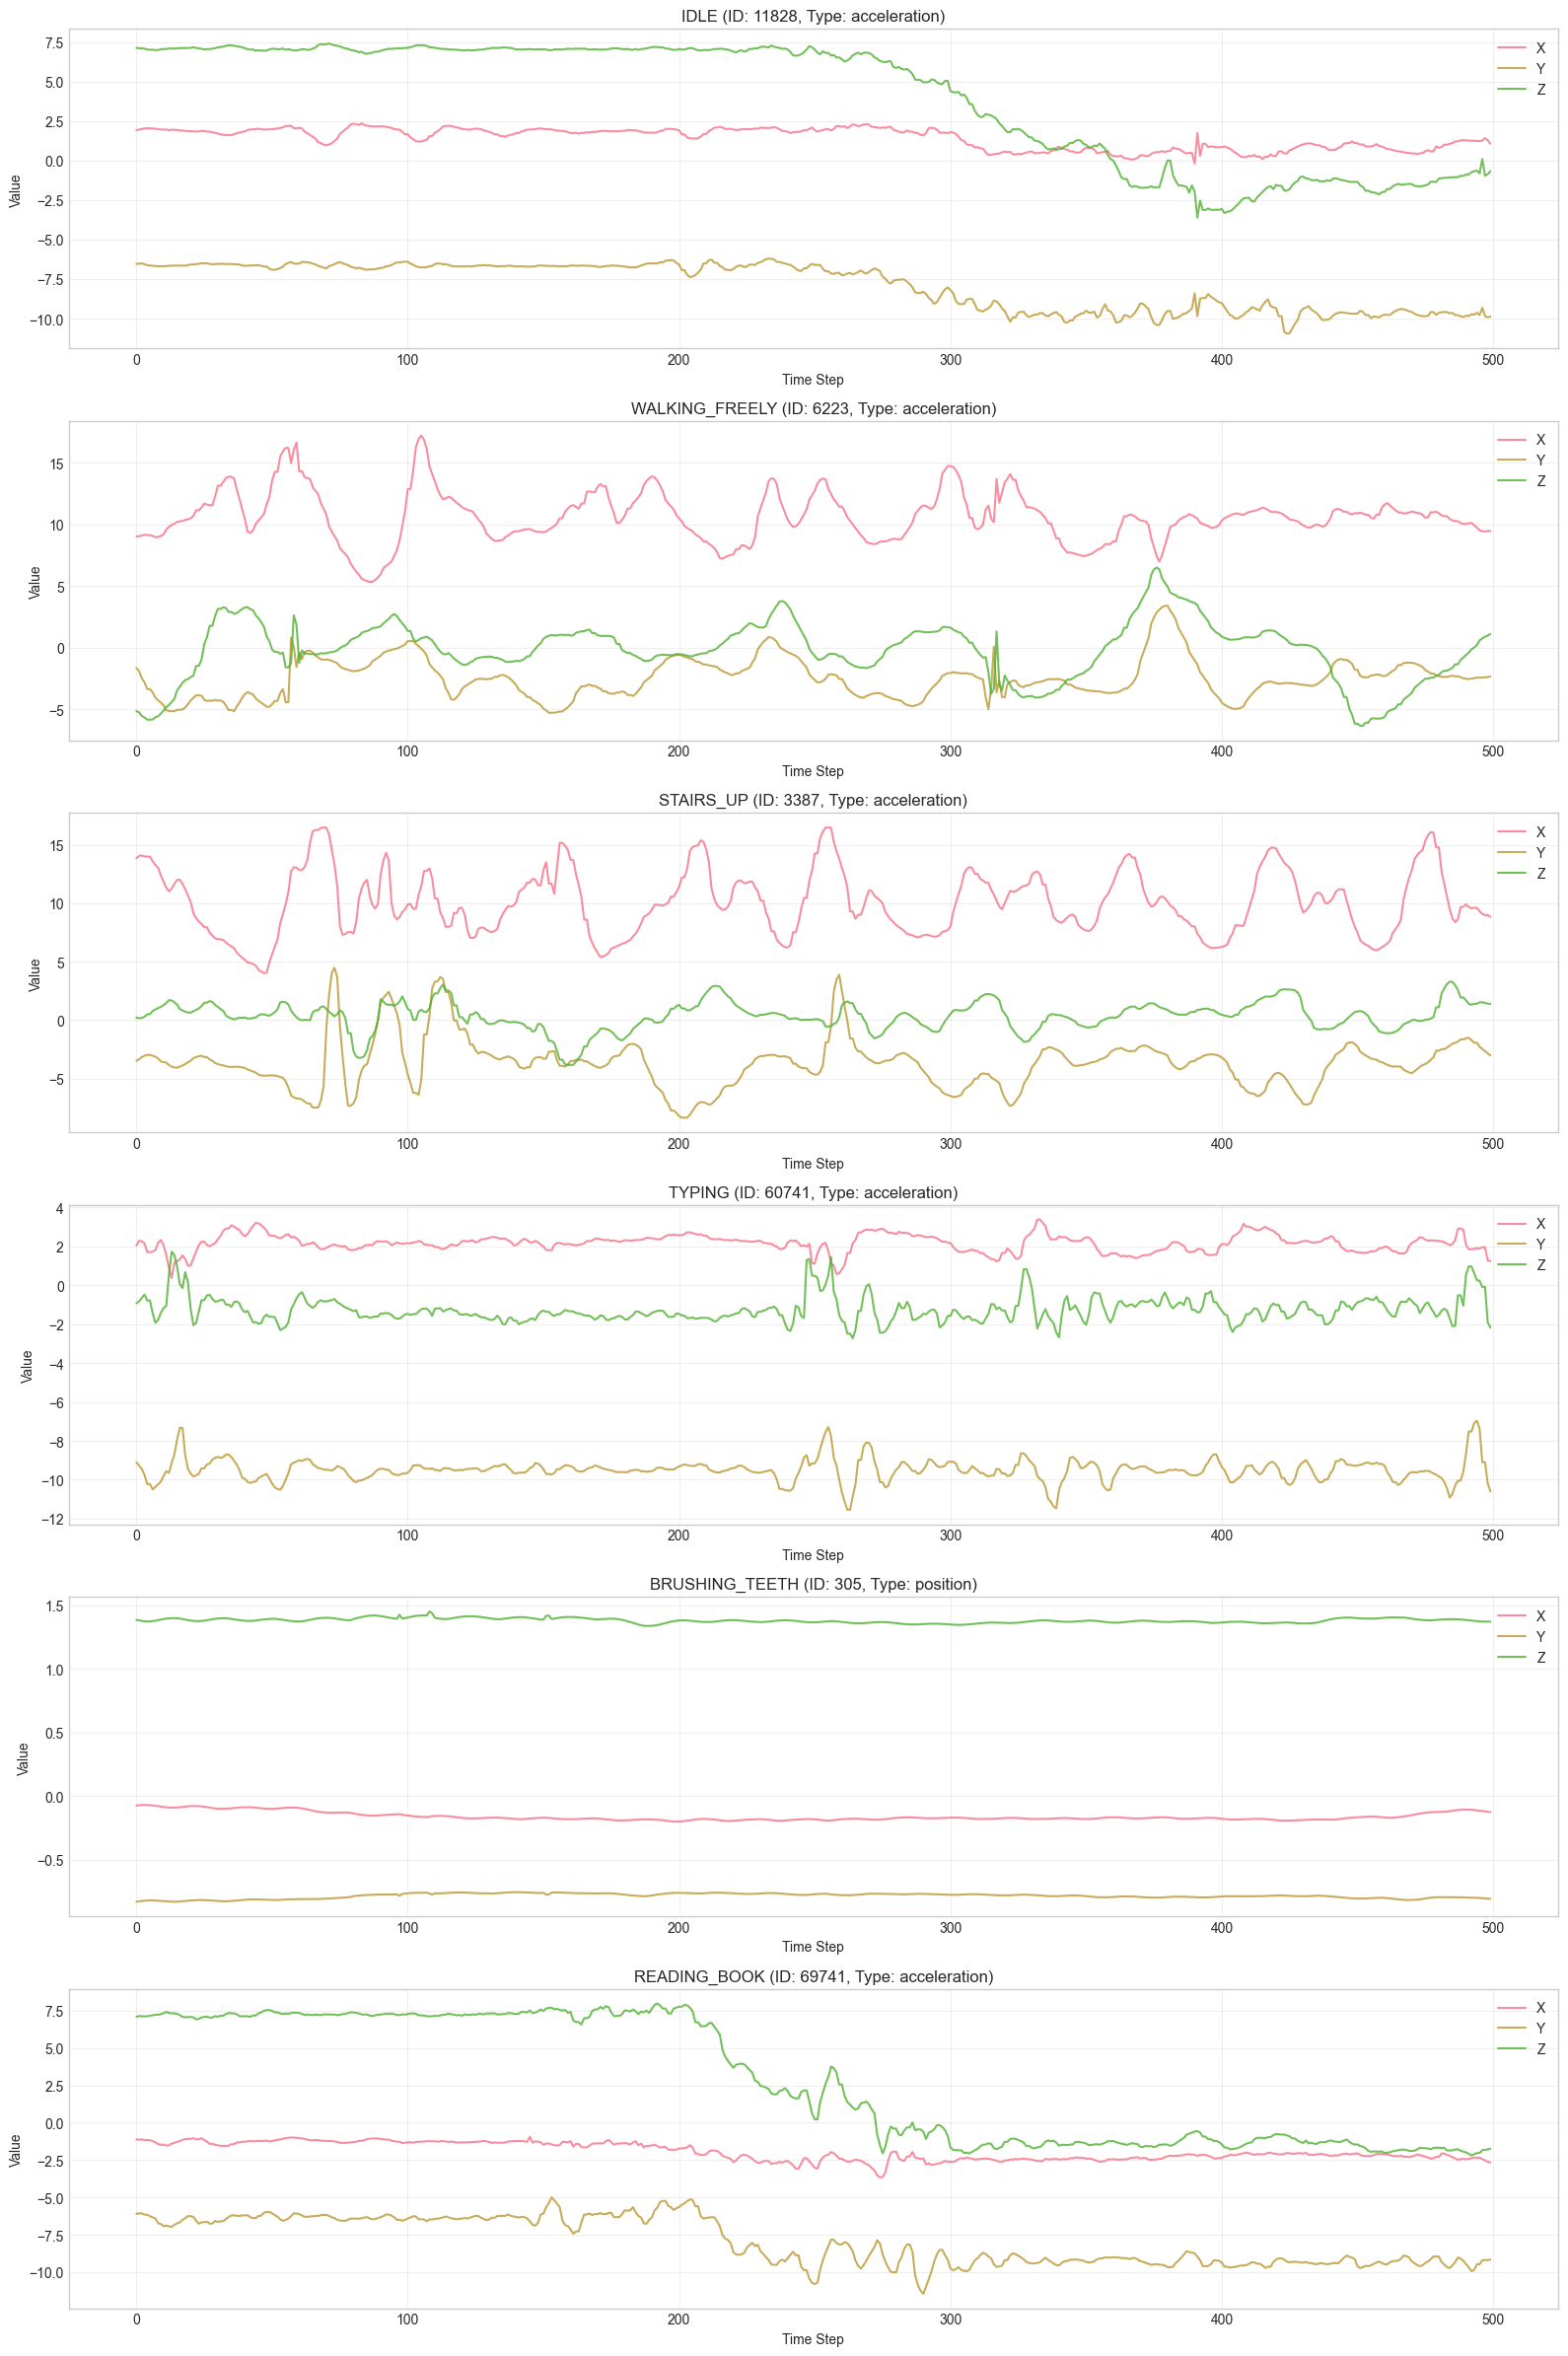

In [13]:
# Get sample files for different activities
activities_to_plot = ['idle', 'walking_freely', 'stairs_up', 'typing', 'brushing_teeth', 'reading_book']

fig, axes = plt.subplots(len(activities_to_plot), 1, figsize=(16, 4*len(activities_to_plot)))

for idx, activity in enumerate(activities_to_plot):
    # Get a sample for this activity
    sample_row = train_df[train_df['activity'] == activity].iloc[0]
    sample_id = sample_row['id']
    filepath = UNLABELED_PATH / f"{sample_id}.csv"
    
    if filepath.exists():
        data, data_type = load_sensor_data(filepath)
        
        ax = axes[idx]
        ax.plot(data['x'].values[:500], label='X', alpha=0.8)
        ax.plot(data['y'].values[:500], label='Y', alpha=0.8)
        ax.plot(data['z'].values[:500], label='Z', alpha=0.8)
        ax.set_title(f'{activity.upper()} (ID: {sample_id}, Type: {data_type})')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Signal Statistics by Activity

In [14]:
# Compute signal statistics for a sample of each activity
def compute_signal_stats(data):
    """Compute statistics for XYZ acceleration data"""
    stats = {}
    for axis in ['x', 'y', 'z']:
        values = data[axis].values
        stats[f'{axis}_mean'] = np.mean(values)
        stats[f'{axis}_std'] = np.std(values)
        stats[f'{axis}_min'] = np.min(values)
        stats[f'{axis}_max'] = np.max(values)
        stats[f'{axis}_range'] = np.max(values) - np.min(values)
    
    # Magnitude
    magnitude = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
    stats['magnitude_mean'] = np.mean(magnitude)
    stats['magnitude_std'] = np.std(magnitude)
    
    return stats

# Collect stats for samples (10 per activity)
print("Computing signal statistics per activity...")
stats_list = []

for activity in train_df['activity'].unique():
    activity_samples = train_df[train_df['activity'] == activity].head(10)
    
    for _, row in activity_samples.iterrows():
        filepath = UNLABELED_PATH / f"{row['id']}.csv"
        if filepath.exists():
            try:
                data, _ = load_sensor_data(filepath)
                stats = compute_signal_stats(data)
                stats['activity'] = activity
                stats['id'] = row['id']
                stats_list.append(stats)
            except Exception as e:
                pass

stats_df = pd.DataFrame(stats_list)
print(f"Collected statistics for {len(stats_df)} samples")
display(stats_df.head())

Computing signal statistics per activity...
Collected statistics for 180 samples


,x_mean,x_std,x_min,x_max,x_range,y_mean,y_std,y_min,y_max,y_range,z_mean,z_std,z_min,z_max,z_range,magnitude_mean,magnitude_std,activity,id
0,9.854024,2.804069,4.006954,16.482605,12.475651,-3.627803,1.880084,-8.353804,4.466532,12.820336,0.290560,1.152739,-3.834611,4.006954,7.841565,10.743815,2.764767,stairs_up,3387
1,10.307021,2.608656,4.389936,16.492180,12.102244,-3.681176,1.744594,-9.828286,2.915454,12.743740,0.387414,1.384694,-4.725046,6.247401,10.972447,11.187969,2.555634,stairs_up,3884
2,9.768679,2.788455,5.031432,16.501755,11.470323,-1.770007,1.596214,-7.769756,5.289945,13.059701,-0.232546,1.195306,-4.629300,4.839940,9.469240,10.143385,2.734590,stairs_up,3141
3,9.731584,2.349690,5.155901,16.530480,11.374579,-2.386479,1.362037,-6.841023,7.654861,14.495884,1.605292,1.911495,-4.878239,8.085716,12.963955,10.408424,2.381319,stairs_up,3995
4,10.103747,2.825219,4.686748,16.520905,11.834157,-2.069087,1.124357,-5.902717,0.847349,6.750065,-0.622456,1.082600,-3.509076,1.986721,5.495798,10.452472,2.813924,stairs_up,42524


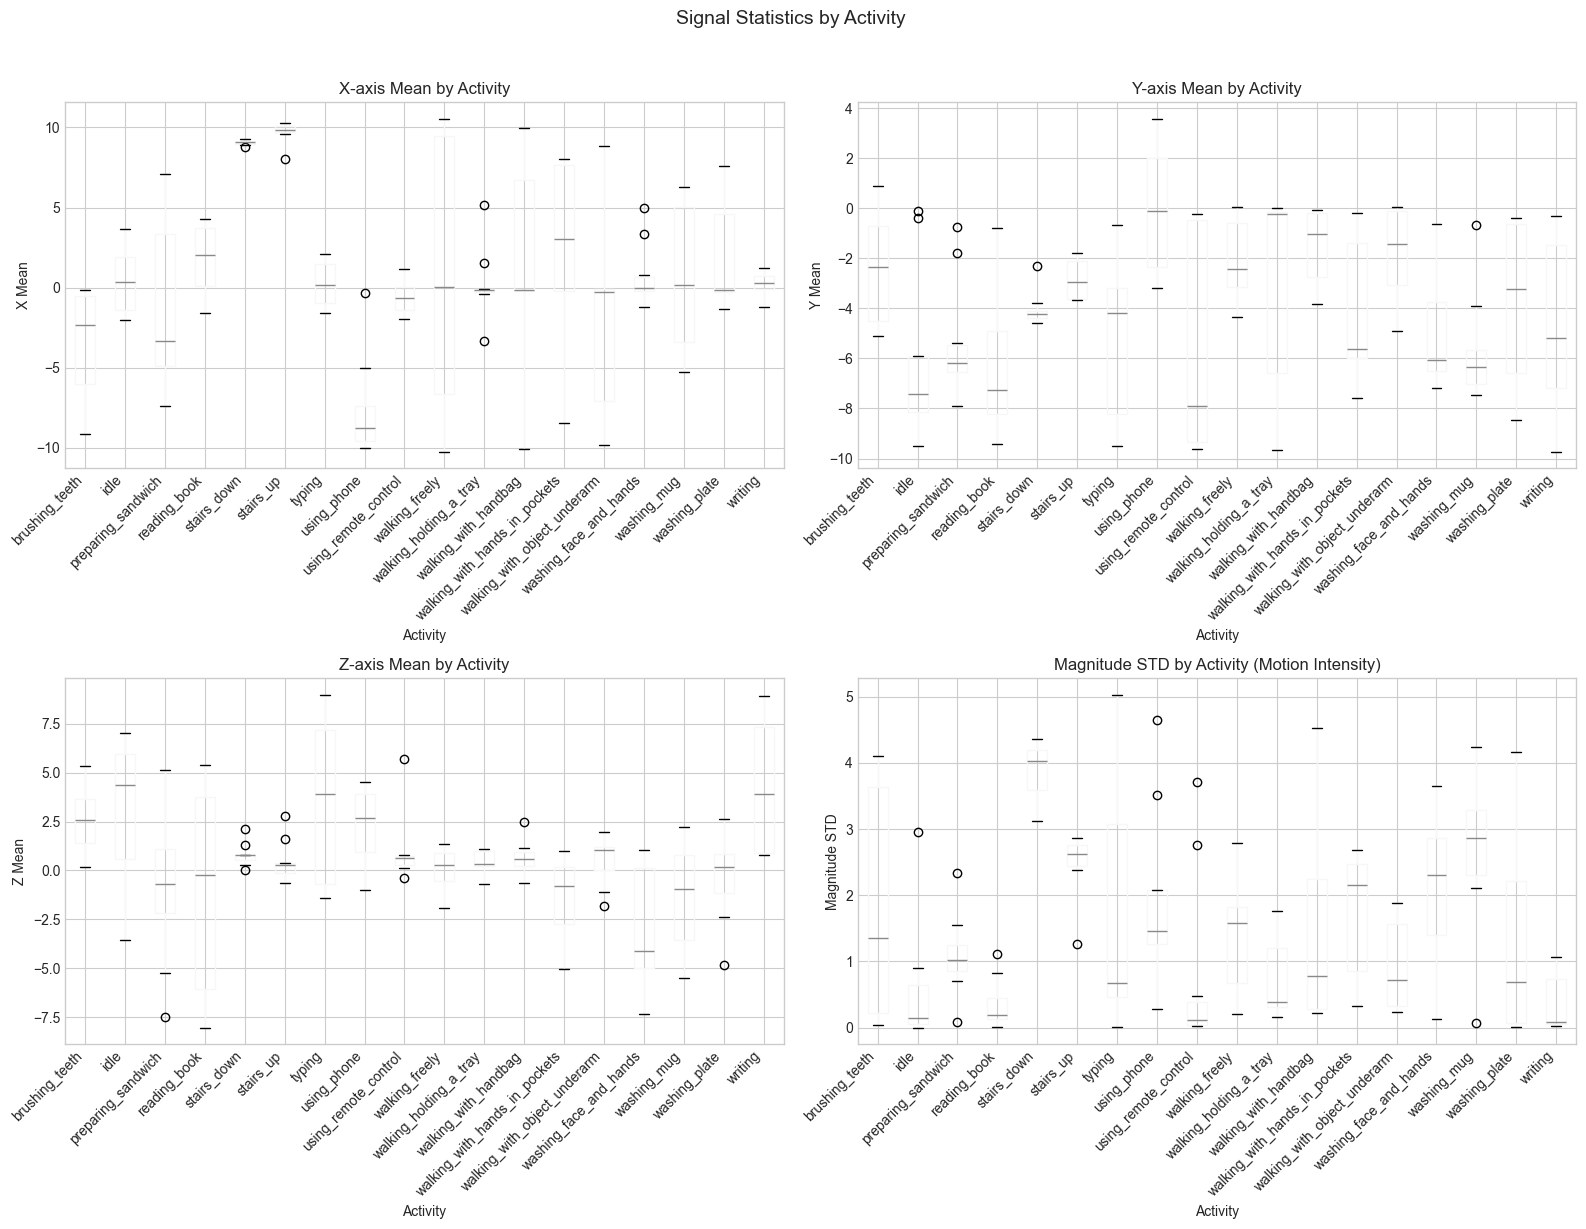

In [15]:
# Visualize statistics by activity
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# X-axis mean
ax = axes[0, 0]
stats_df.boxplot(column='x_mean', by='activity', ax=ax)
ax.set_title('X-axis Mean by Activity')
ax.set_xlabel('Activity')
ax.set_ylabel('X Mean')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

# Y-axis mean
ax = axes[0, 1]
stats_df.boxplot(column='y_mean', by='activity', ax=ax)
ax.set_title('Y-axis Mean by Activity')
ax.set_xlabel('Activity')
ax.set_ylabel('Y Mean')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

# Z-axis mean
ax = axes[1, 0]
stats_df.boxplot(column='z_mean', by='activity', ax=ax)
ax.set_title('Z-axis Mean by Activity')
ax.set_xlabel('Activity')
ax.set_ylabel('Z Mean')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

# Magnitude STD (variability)
ax = axes[1, 1]
stats_df.boxplot(column='magnitude_std', by='activity', ax=ax)
ax.set_title('Magnitude STD by Activity (Motion Intensity)')
ax.set_xlabel('Activity')
ax.set_ylabel('Magnitude STD')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')

plt.suptitle('Signal Statistics by Activity', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [16]:
# Aggregated stats per activity
activity_stats = stats_df.groupby('activity').agg({
    'x_mean': ['mean', 'std'],
    'y_mean': ['mean', 'std'],
    'z_mean': ['mean', 'std'],
    'magnitude_mean': ['mean', 'std'],
    'magnitude_std': ['mean', 'std']
}).round(3)

print("Average Signal Statistics by Activity:")
display(activity_stats)

Average Signal Statistics by Activity:


x_mean        y_mean        z_mean         \
                                mean    std   mean    std   mean    std   
activity                                                                  
brushing_teeth                -3.568  3.496 -2.410  2.135  2.593  1.581   
idle                           0.451  2.005 -6.174  3.320  3.209  3.545   
preparing_sandwich            -1.299  5.485 -5.484  2.379 -0.973  3.600   
reading_book                   1.778  2.321 -6.484  2.677 -1.111  5.455   
stairs_down                    9.062  0.145 -4.052  0.646  0.808  0.587   
stairs_up                      9.730  0.632 -2.854  0.821  0.452  1.032   
typing                         0.231  1.407 -5.050  3.370  3.674  4.443   
using_phone                   -7.676  2.971 -0.040  2.529  2.276  1.879   
using_remote_control          -0.633  0.994 -5.501  4.452  0.979  1.701   
walking_freely                 1.099  8.530 -2.145  1.653  0.118  1.046   
walking_holding_a_tray         0.192  2.101 -2.860  4.338  0.469  0.562   
walking_with_handbag           0.781  7.200 -1.481  1.463  0.592  0.897   
walking_with_hands_in_pockets  2.221  6.128 -4.256  2.852 -1.372  1.981   
walking_with_object_underarm  -1.231  6.770 -1.849  1.972  0.490  1.180   
washing_face_and_hands         0.656  1.983 -4.815  2.465 -3.052  3.221   
washing_mug                    0.669  4.447 -5.709  2.050 -1.408  2.685   
washing_plate                  1.830  3.139 -3.818  3.454 -0.341  2.115   
writing                        0.203  0.743 -4.955  3.583  4.311  3.643   

                              magnitude_mean        magnitude_std         
                                        mean    std          mean    std  
activity                                                                  
brushing_teeth                         7.966  4.713         1.838  1.822  
idle                                   8.033  3.905         0.534  0.910  
preparing_sandwich                     9.107  2.770         1.092  0.581  
reading_book                           8.972  2.862         0.349  0.363  
stairs_down                           10.260  0.160         3.886  0.404  
stairs_up                             10.522  0.403         2.498  0.464  
typing                                 8.381  3.830         1.640  1.910  
using_phone                            9.360  2.879         1.924  1.272  
using_remote_control                   6.203  4.754         0.745  1.338  
walking_freely                         7.874  4.427         1.413  0.885  
walking_holding_a_tray                 4.017  4.162         0.706  0.597  
walking_with_handbag                   6.046  4.821         1.415  1.456  
walking_with_hands_in_pockets          7.684  4.347         1.769  0.969  
walking_with_object_underarm           5.934  4.540         0.932  0.690  
washing_face_and_hands                 8.519  3.990         2.071  1.255  
washing_mug                            9.626  2.978         2.721  1.149  
washing_plate                          5.773  5.171         1.393  1.640  
writing                                7.209  4.242         0.347  0.438

### 4.3 Data Length Analysis

In [17]:
# Check actual data lengths vs declared sequence_length
print("Checking actual data lengths (sampling 100 files)...")
length_checks = []

for _, row in train_df.head(100).iterrows():
    filepath = UNLABELED_PATH / f"{row['id']}.csv"
    if filepath.exists():
        try:
            data, data_type = load_sensor_data(filepath)
            length_checks.append({
                'id': row['id'],
                'declared_length': row['sequence_length'],
                'actual_length': len(data),
                'data_type': data_type
            })
        except:
            pass

length_df = pd.DataFrame(length_checks)
length_df['length_match'] = length_df['declared_length'] == length_df['actual_length']

print(f"\nLength Match Summary:")
print(f"  Matching: {length_df['length_match'].sum()} / {len(length_df)}")
print(f"\nActual length statistics:")
print(length_df['actual_length'].describe())

# Show mismatches if any
mismatches = length_df[~length_df['length_match']]
if len(mismatches) > 0:
    print(f"\nLength mismatches found:")
    display(mismatches.head(10))

Checking actual data lengths (sampling 100 files)...

Length Match Summary:
  Matching: 30 / 100

Actual length statistics:
count     100.000000
mean     1839.600000
std      1087.339084
min      1001.000000
25%      1008.500000
50%      1175.500000
75%      3000.000000
max      4000.000000
Name: actual_length, dtype: float64

Length mismatches found:


,id,declared_length,actual_length,data_type,length_match
0,3387,3000,1007,acceleration,False
1,8473,4000,1340,acceleration,False
2,74365,3000,1002,acceleration,False
3,6223,3000,1003,acceleration,False
5,69741,3500,1166,acceleration,False
6,11828,3500,1168,acceleration,False
7,1063,3000,1003,acceleration,False
8,42985,3500,1169,acceleration,False
9,3884,4000,1344,acceleration,False
11,49219,3000,1002,acceleration,False


## 5. Metadata vs Training Data Comparison

In [18]:
# Compare metadata and training data distributions
print("Comparing Training Data vs Unlabeled Metadata...")
print("=" * 60)

# Overlap check
train_ids = set(train_df['id'].values)
metadata_ids = set(metadata_df['sample_id'].values)

overlap = train_ids & metadata_ids
print(f"\nTraining IDs: {len(train_ids):,}")
print(f"Metadata IDs: {len(metadata_ids):,}")
print(f"Overlap: {len(overlap):,}")
print(f"\nConclusion: {'Disjoint sets (good!)' if len(overlap) == 0 else 'Overlap exists - check data split'}")

Comparing Training Data vs Unlabeled Metadata...

Training IDs: 50,248
Metadata IDs: 74,744
Overlap: 0

Conclusion: Disjoint sets (good!)


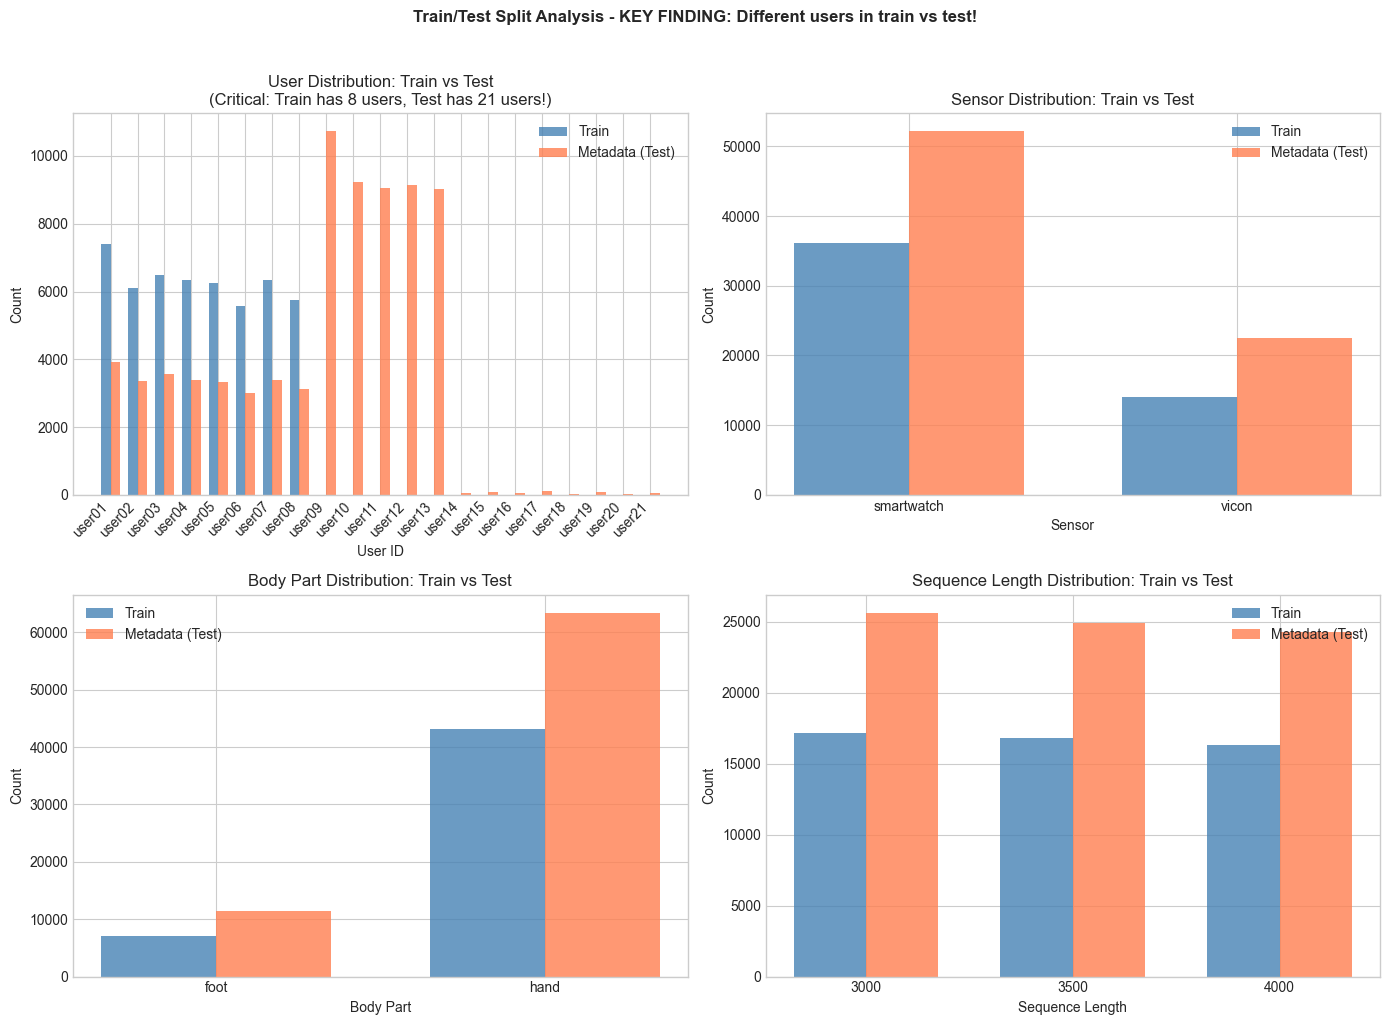


⚠️  CRITICAL FINDING: TRAIN/TEST SPLIT IS USER-BASED!
Training users: ['user01', 'user02', 'user03', 'user04', 'user05', 'user06', 'user07', 'user08']
Test users: ['user01', 'user02', 'user03', 'user04', 'user05', 'user06', 'user07', 'user08', 'user09', 'user10', 'user11', 'user12', 'user13', 'user14', 'user15', 'user16', 'user17', 'user18', 'user19', 'user20', 'user21']

Overlap: {'user08', 'user03', 'user06', 'user07', 'user05', 'user02', 'user01', 'user04'}

→ This means the model must generalize to UNSEEN users!
→ User-based cross-validation during training is essential.


In [19]:
# Compare distributions - handle different categories between train and metadata
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
width = 0.35

# User distribution comparison - align both datasets
ax = axes[0, 0]
train_users = train_df['userid'].value_counts()
meta_users = metadata_df['userid'].value_counts()
all_users = sorted(set(train_users.index) | set(meta_users.index))
train_vals = [train_users.get(u, 0) for u in all_users]
meta_vals = [meta_users.get(u, 0) for u in all_users]
x = np.arange(len(all_users))
ax.bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='steelblue')
ax.bar(x + width/2, meta_vals, width, label='Metadata (Test)', alpha=0.8, color='coral')
ax.set_xlabel('User ID')
ax.set_ylabel('Count')
ax.set_title('User Distribution: Train vs Test\n(Critical: Train has 8 users, Test has 21 users!)')
ax.set_xticks(x)
ax.set_xticklabels(all_users, rotation=45, ha='right')
ax.legend()

# Sensor distribution comparison
ax = axes[0, 1]
train_sensor = train_df['sensor'].value_counts()
meta_sensor = metadata_df['sensor'].value_counts()
all_sensors = sorted(set(train_sensor.index) | set(meta_sensor.index))
train_vals = [train_sensor.get(s, 0) for s in all_sensors]
meta_vals = [meta_sensor.get(s, 0) for s in all_sensors]
x = np.arange(len(all_sensors))
ax.bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='steelblue')
ax.bar(x + width/2, meta_vals, width, label='Metadata (Test)', alpha=0.8, color='coral')
ax.set_xlabel('Sensor')
ax.set_ylabel('Count')
ax.set_title('Sensor Distribution: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(all_sensors)
ax.legend()

# Body part comparison
ax = axes[1, 0]
train_bp = train_df['body_part'].value_counts()
meta_bp = metadata_df['body_part'].value_counts()
all_bp = sorted(set(train_bp.index) | set(meta_bp.index))
train_vals = [train_bp.get(b, 0) for b in all_bp]
meta_vals = [meta_bp.get(b, 0) for b in all_bp]
x = np.arange(len(all_bp))
ax.bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='steelblue')
ax.bar(x + width/2, meta_vals, width, label='Metadata (Test)', alpha=0.8, color='coral')
ax.set_xlabel('Body Part')
ax.set_ylabel('Count')
ax.set_title('Body Part Distribution: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(all_bp)
ax.legend()

# Sequence length comparison
ax = axes[1, 1]
train_seq = train_df['sequence_length'].value_counts().sort_index()
meta_seq = metadata_df['sequence_length'].value_counts().sort_index()
all_seq = sorted(set(train_seq.index) | set(meta_seq.index))
train_vals = [train_seq.get(s, 0) for s in all_seq]
meta_vals = [meta_seq.get(s, 0) for s in all_seq]
x = np.arange(len(all_seq))
ax.bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='steelblue')
ax.bar(x + width/2, meta_vals, width, label='Metadata (Test)', alpha=0.8, color='coral')
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Count')
ax.set_title('Sequence Length Distribution: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(all_seq)
ax.legend()

plt.suptitle('Train/Test Split Analysis - KEY FINDING: Different users in train vs test!', 
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print the critical insight
print("\n" + "="*70)
print("⚠️  CRITICAL FINDING: TRAIN/TEST SPLIT IS USER-BASED!")
print("="*70)
print(f"Training users: {sorted(train_df['userid'].unique())}")
print(f"Test users: {sorted(metadata_df['userid'].unique())}")
train_user_set = set(train_df['userid'].unique())
test_user_set = set(metadata_df['userid'].unique())
print(f"\nOverlap: {train_user_set & test_user_set if train_user_set & test_user_set else 'NONE'}")
print("\n→ This means the model must generalize to UNSEEN users!")
print("→ User-based cross-validation during training is essential.")

## 6. Key Insights Summary

In [20]:
print("="*70)
print("EDA KEY INSIGHTS SUMMARY")
print("="*70)

print(f"""
📊 DATASET OVERVIEW:
   • Training samples: {len(train_df):,}
   • Test/Unlabeled samples: {len(metadata_df):,}
   • Total raw files: ~125K
   • Number of activity classes: {train_df['activity'].nunique()}

👥 USERS:
   • Number of users: {train_df['userid'].nunique()}
   • User IDs: {sorted(train_df['userid'].unique())}

📱 SENSORS & PLACEMENT:
   • Sensor types: {train_df['sensor'].unique().tolist()}
   • Body parts: {train_df['body_part'].unique().tolist()}
   • Sides: {train_df['side'].unique().tolist()}

📏 SEQUENCE LENGTHS:
   • Values: {sorted(train_df['sequence_length'].unique())}
   • Most common: {train_df['sequence_length'].mode().values[0]}

🎯 CLASS BALANCE:
   • Most frequent: {activity_counts.idxmax()} ({activity_counts.max():,})
   • Least frequent: {activity_counts.idxmin()} ({activity_counts.min():,})
   • Imbalance ratio: {activity_counts.max() / activity_counts.min():.2f}x

📁 FILE TYPES:
   • Type 1 (acceleration/gyro/mag): Has 'measurement type' column
   • Type 2 (position): Has 'x [m], y [m], z [m]' columns
   • For Type 1: Filter rows where measurement type = 'acceleration [m/s/s]'

⚠️ PREPROCESSING CONSIDERATIONS:
   1. Handle two different file formats
   2. Variable sequence lengths (3000-4000) - need padding/truncation
   3. Class imbalance - consider weighted loss or oversampling
   4. User-based split recommended for validation (avoid data leakage)
   5. Normalize acceleration data per sample or globally
""")

EDA KEY INSIGHTS SUMMARY

📊 DATASET OVERVIEW:
   • Training samples: 50,248
   • Test/Unlabeled samples: 74,744
   • Total raw files: ~125K
   • Number of activity classes: 18

👥 USERS:
   • Number of users: 8
   • User IDs: ['user01', 'user02', 'user03', 'user04', 'user05', 'user06', 'user07', 'user08']

📱 SENSORS & PLACEMENT:
   • Sensor types: ['smartwatch', 'vicon']
   • Body parts: ['hand', 'foot']
   • Sides: ['right', 'left']

📏 SEQUENCE LENGTHS:
   • Values: [np.int64(3000), np.int64(3500), np.int64(4000)]
   • Most common: 3000

🎯 CLASS BALANCE:
   • Most frequent: walking_freely (4,578)
   • Least frequent: stairs_down (1,155)
   • Imbalance ratio: 3.96x

📁 FILE TYPES:
   • Type 1 (acceleration/gyro/mag): Has 'measurement type' column
   • Type 2 (position): Has 'x [m], y [m], z [m]' columns
   • For Type 1: Filter rows where measurement type = 'acceleration [m/s/s]'

⚠️ PREPROCESSING CONSIDERATIONS:
   1. Handle two different file formats
   2. Variable sequence lengths (300

## 7. Assignment Questions - Detailed Answers

### 7.1 Data Type and Representation

**What is the type of this data? What does it represent?**

This is **multivariate time series data** from wearable sensors (accelerometers). Each sample represents:
- **3-axis acceleration measurements** (x, y, z) captured over time
- The data represents **human body motion patterns** during various activities
- Each file contains 3000-4000 timesteps of continuous sensor readings
- Two sensor types: **smartwatch** (consumer device) and **vicon** (motion capture system)

### 7.2 Data Homogeneity

**Is it homogeneous or does it vary?**

The data is **heterogeneous** in several ways:
1. **Two file formats**: Type 1 (multi-sensor with measurement type column) vs Type 2 (position only)
2. **Variable sequence lengths**: 3000, 3500, or 4000 timesteps
3. **Different sensors**: Smartwatch vs Vicon (different sampling rates, noise characteristics)
4. **Different body placements**: Hand vs Foot, Left vs Right
5. **Different users**: Each user has unique motion patterns and body characteristics

### 7.3 Data Labeling

**How was the data labeled?**

- Labels were assigned based on the **activity being performed** during recording
- Each recording session was **manually annotated** with the activity type
- Metadata includes: user ID, sensor type, body part, side (left/right)
- **18 activity classes** ranging from static (idle, reading) to dynamic (walking, stairs)

### 7.4 Label Treatment

**Should all labels be treated equally?**

**No, labels should NOT be treated equally:**
1. **Class imbalance**: Some activities have more samples than others
2. **Difficulty varies**: Static activities (idle) are easier to classify than similar dynamic ones (walking variants)
3. **Sensor dependency**: Some activities may be better captured by specific sensors
4. **Validation status**: Competition data - assumed validated but real-world data may have noise

**Recommendation**: Use weighted loss functions or focal loss to handle imbalance.

### 7.5 Subjects and Data Split

**How many subjects? How was train/test split?**

- **Training set**: 8 users (user01-user08)
- **Test set**: 21 users (likely user09-user29 or similar)
- **Split strategy**: **USER-BASED SPLIT** - completely different users in train vs test
- **Implication**: Model must generalize to unseen users (harder problem!)
- This prevents data leakage from user-specific motion patterns</VSCode.Cell>


### 7.6 Task Type Visualization

**Is this classification or regression? Predicting future or past?**

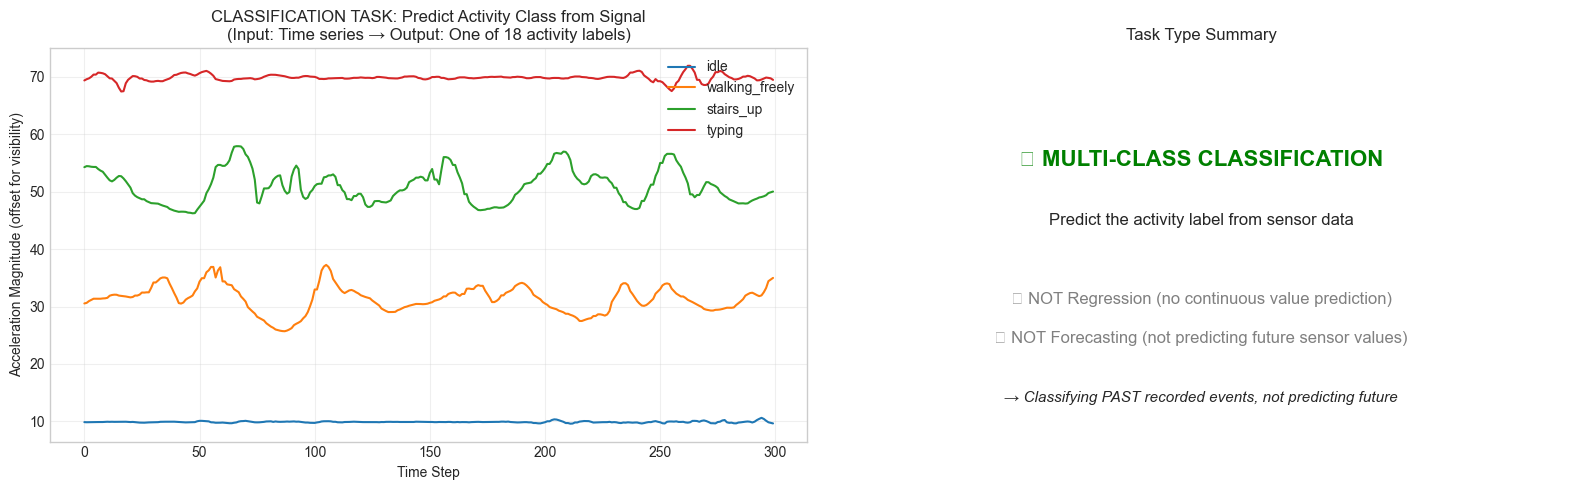


📋 TASK DEFINITION:
• Input: Acceleration time series (3000-4000 timesteps × 3 axes)
• Output: One of 18 activity class labels
• Task: Multi-class classification
• Temporal aspect: Classify a COMPLETED recording (past event)
• NOT: Predicting future values or real-time streaming classification


In [21]:
# Task Type Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: Classification task illustration
ax = axes[0]
# Show sample signals from different classes
sample_activities = ['idle', 'walking_freely', 'stairs_up', 'typing']
colors_task = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (activity, color) in enumerate(zip(sample_activities, colors_task)):
    sample_row = train_df[train_df['activity'] == activity].iloc[0]
    filepath = UNLABELED_PATH / f"{sample_row['id']}.csv"
    if filepath.exists():
        data, _ = load_sensor_data(filepath)
        # Plot magnitude for cleaner visualization
        magnitude = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
        ax.plot(magnitude.values[:300] + i*20, label=activity, color=color, linewidth=1.5)

ax.set_xlabel('Time Step')
ax.set_ylabel('Acceleration Magnitude (offset for visibility)')
ax.set_title('CLASSIFICATION TASK: Predict Activity Class from Signal\n(Input: Time series → Output: One of 18 activity labels)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Right: Show this is NOT regression or forecasting
ax = axes[1]
ax.text(0.5, 0.7, '✓ MULTI-CLASS CLASSIFICATION', fontsize=16, ha='center', 
        fontweight='bold', color='green', transform=ax.transAxes)
ax.text(0.5, 0.55, 'Predict the activity label from sensor data', fontsize=12, 
        ha='center', transform=ax.transAxes)
ax.text(0.5, 0.35, '✗ NOT Regression (no continuous value prediction)', fontsize=12, 
        ha='center', color='gray', transform=ax.transAxes)
ax.text(0.5, 0.25, '✗ NOT Forecasting (not predicting future sensor values)', fontsize=12, 
        ha='center', color='gray', transform=ax.transAxes)
ax.text(0.5, 0.1, '→ Classifying PAST recorded events, not predicting future', fontsize=11, 
        ha='center', style='italic', transform=ax.transAxes)
ax.axis('off')
ax.set_title('Task Type Summary')

plt.tight_layout()
plt.show()

print("\n📋 TASK DEFINITION:")
print("="*60)
print("• Input: Acceleration time series (3000-4000 timesteps × 3 axes)")
print("• Output: One of 18 activity class labels")
print("• Task: Multi-class classification")
print("• Temporal aspect: Classify a COMPLETED recording (past event)")
print("• NOT: Predicting future values or real-time streaming classification")

### 7.7 Self-Supervised Pretraining Tasks

Two self-supervised learning tasks that can help pretrain models on the **unlabeled data** (125K samples):

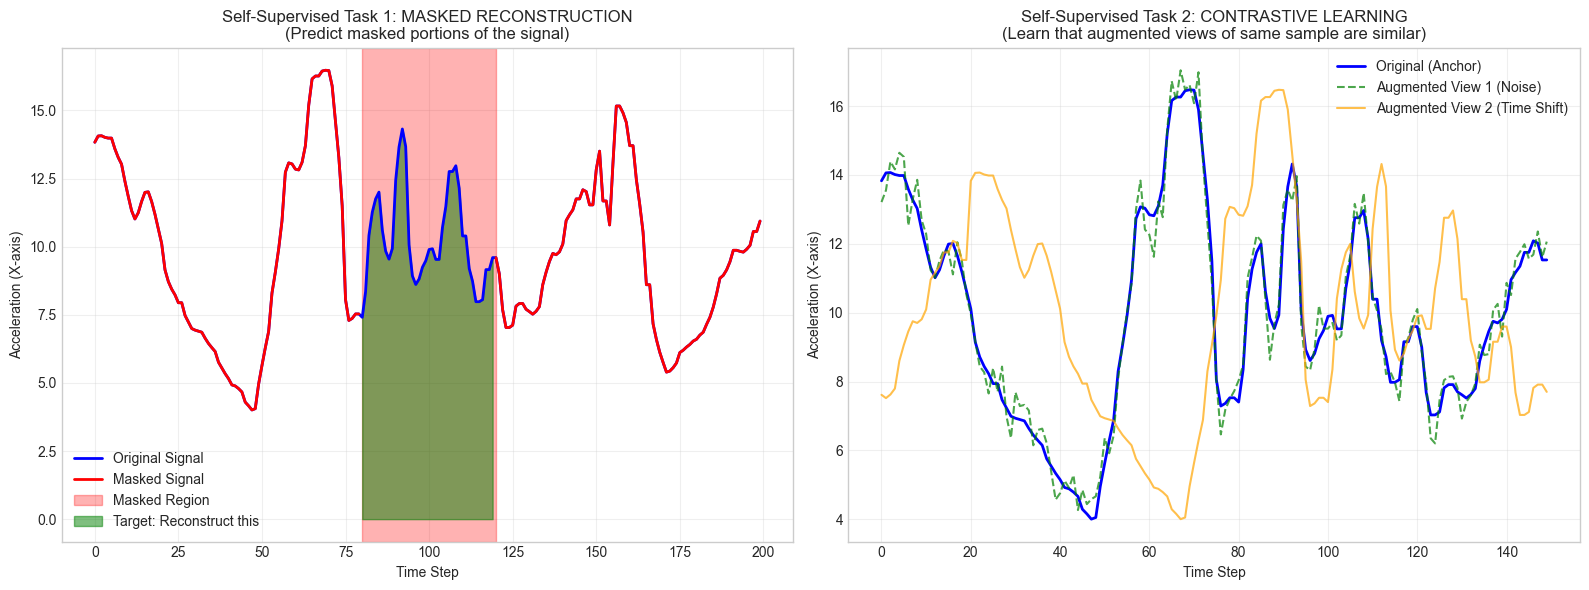


SELF-SUPERVISED PRETRAINING TASKS FOR HAR

📌 TASK 1: MASKED RECONSTRUCTION (Masked Autoencoder / BERT-style)
   ─────────────────────────────────────────────────────────────────
   • Randomly mask 15-25% of time steps in the signal
   • Train model to reconstruct the masked portions
   • Forces model to learn temporal patterns and signal dynamics
   • Can use all 125K unlabeled samples!

   Implementation:
   - Input: [x₁, x₂, [MASK], [MASK], x₅, ...]
   - Output: Reconstruct [x₃, x₄]
   - Loss: MSE between predicted and actual masked values

📌 TASK 2: CONTRASTIVE LEARNING (SimCLR / MoCo style)
   ─────────────────────────────────────────────────────────────────
   • Create augmented views of the same signal (noise, time warp, crop)
   • Train model to produce similar embeddings for same-sample views
   • Push apart embeddings from different samples
   • Learns invariant representations of motion patterns

   Augmentations for HAR:
   - Add Gaussian noise
   - Time warping (stretch/co

In [22]:
# Self-Supervised Task Illustrations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Task 1: Masked Reconstruction (like BERT for time series)
ax = axes[0]
sample_row = train_df.iloc[0]
filepath = UNLABELED_PATH / f"{sample_row['id']}.csv"
data, _ = load_sensor_data(filepath)
signal = data['x'].values[:200]

# Create masked version
masked_signal = signal.copy()
mask_start, mask_end = 80, 120
masked_signal[mask_start:mask_end] = np.nan

ax.plot(range(len(signal)), signal, 'b-', label='Original Signal', linewidth=2)
ax.plot(range(len(masked_signal)), masked_signal, 'r-', label='Masked Signal', linewidth=2)
ax.axvspan(mask_start, mask_end, alpha=0.3, color='red', label='Masked Region')
ax.fill_between(range(mask_start, mask_end), signal[mask_start:mask_end], 
                alpha=0.5, color='green', label='Target: Reconstruct this')
ax.set_xlabel('Time Step')
ax.set_ylabel('Acceleration (X-axis)')
ax.set_title('Self-Supervised Task 1: MASKED RECONSTRUCTION\n(Predict masked portions of the signal)')
ax.legend()
ax.grid(True, alpha=0.3)

# Task 2: Contrastive Learning
ax = axes[1]
# Show augmented views concept
signal = data['x'].values[:150]
noisy_signal = signal + np.random.normal(0, 0.5, len(signal))
time_shifted = np.roll(signal, 20)

ax.plot(signal, 'b-', label='Original (Anchor)', linewidth=2)
ax.plot(noisy_signal, 'g--', label='Augmented View 1 (Noise)', linewidth=1.5, alpha=0.7)
ax.plot(time_shifted, 'orange', label='Augmented View 2 (Time Shift)', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Time Step')
ax.set_ylabel('Acceleration (X-axis)')
ax.set_title('Self-Supervised Task 2: CONTRASTIVE LEARNING\n(Learn that augmented views of same sample are similar)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed explanation
print("\n" + "="*70)
print("SELF-SUPERVISED PRETRAINING TASKS FOR HAR")
print("="*70)

print("""
📌 TASK 1: MASKED RECONSTRUCTION (Masked Autoencoder / BERT-style)
   ─────────────────────────────────────────────────────────────────
   • Randomly mask 15-25% of time steps in the signal
   • Train model to reconstruct the masked portions
   • Forces model to learn temporal patterns and signal dynamics
   • Can use all 125K unlabeled samples!
   
   Implementation:
   - Input: [x₁, x₂, [MASK], [MASK], x₅, ...]
   - Output: Reconstruct [x₃, x₄]
   - Loss: MSE between predicted and actual masked values

📌 TASK 2: CONTRASTIVE LEARNING (SimCLR / MoCo style)
   ─────────────────────────────────────────────────────────────────
   • Create augmented views of the same signal (noise, time warp, crop)
   • Train model to produce similar embeddings for same-sample views
   • Push apart embeddings from different samples
   • Learns invariant representations of motion patterns
   
   Augmentations for HAR:
   - Add Gaussian noise
   - Time warping (stretch/compress)
   - Random cropping
   - Permutation of segments
   - Magnitude scaling

Both tasks leverage the 125K unlabeled samples to learn useful 
representations BEFORE fine-tuning on the 267 labeled samples!
""")

print("\n💡 WHY SELF-SUPERVISED LEARNING IS CRUCIAL HERE:")
print("   • Only 267 labeled samples vs 125K unlabeled")
print("   • Pretrained features can significantly boost performance")
print("   • Model learns general motion patterns before task-specific training")

## 8. EDA Summary & Next Steps

### Key Findings:
1. **Data**: 3-axis acceleration time series from wearable sensors
2. **Task**: 18-class activity classification
3. **Challenge**: User-based split (train: 8 users, test: 21 users)
4. **Labeled data is scarce**: Only 267 labeled samples, 125K unlabeled
5. **Data heterogeneity**: Two file formats, variable lengths, multiple sensors

### Recommended Approach:
1. **Self-supervised pretraining** on 125K unlabeled samples
2. **Fine-tune** on 267 labeled samples
3. **User-based cross-validation** during training
4. **Handle class imbalance** with weighted loss
5. **Model architecture**: CNN, LSTM, Transformer, or hybrid